<a href="https://colab.research.google.com/github/njones61/ce544/blob/main/docs/unit1/09_dewatering/dewatering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construction Dewatering

This notebook is used to design dewatering systems for excavations in unconfined aquifers. It uses well equations to calculate the drawdown for a series of dewatering wells. The excavation size and location are specified using GeoJSON file. The dewatering algorithm and the steps involved in using this notebook are documented here:

https://byu-ce544.readthedocs.io/en/latest/unit1/09_dewatering/dewatering_class/

This notebook can be used to simulate drawdown from construction dewatering at any location using a GEOJSON file to define the excavation. It assumes a simple unconfined aquifer underlain by an impermeable layer.

# Part 1 - Setup

In this section we import the packages we will need, upload the excavation polygon, and manually create some well locations to analyze.

In [ ]:
%%capture
!pip install geopandas
!pip install ipyleaflet

In [ ]:
from ipyleaflet import Map, Polygon, Marker, DrawControl, GeoJSON, LayerGroup
from ipywidgets import HTML
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
import pyproj
from shapely.geometry import shape, Point, Polygon


In [ ]:
# Upload GEOJSON file
from google.colab import files
uploaded = files.upload()

# get name of uploaded file
file_name = list(uploaded.keys())[0]

Saving byu_brewster.geojson to byu_brewster.geojson


In [ ]:
# Load GEOJSON for Polygon and extract coordinates
geojson_file = file_name  # path to your GEOJSON file
polygon_data = gpd.read_file(geojson_file)
geojson_data = polygon_data.__geo_interface__
polygon_coords = list(polygon_data.geometry[0].exterior.coords)  # Extract exterior coords

# swap the orders of the pairs in polygon_coords
polygon_coords = [(y, x) for x, y in polygon_coords]
polygon_coords

[(40.246851678806706, -111.64554864779842),
 (40.24610895796758, -111.6455446101439),
 (40.24610895796758, -111.64368728911117),
 (40.246854760619016, -111.6436953644202),
 (40.246851678806706, -111.64554864779842)]

In [ ]:
# Create a polygon using the polygon_coords and add it to an ipyleaflet map

polygon = GeoJSON(
    data=geojson_data,
    style={
        'color': 'blue',
        'fillColor': 'gray',
        'fillOpacity': 0.2,
        'weight': 2
    }
)

center = [polygon_data.geometry[0].centroid.y, polygon_data.geometry[0].centroid.x]
m = Map(center=center, zoom=18)
m.add(polygon)

# Create a DrawControl for user to click and add markers
draw_control = DrawControl(marker={"shapeOptions": {"color": "#0000FF"}})

# Store marker coordinates
marker_coords = []

# Function to add markers and store their coordinates
def handle_marker(event=None, action=None, geo_json=None):
    if action == 'created' and geo_json['geometry']['type'] == 'Point':
        lat, lng = geo_json['geometry']['coordinates'][1], geo_json['geometry']['coordinates'][0]
        marker_coords.append((lat, lng))  # Store each marker's coordinates
        marker = Marker(location=(lat, lng), draggable=False)
        m.add_layer(marker)

# Attach the marker handler to draw control
draw_control.on_draw(handle_marker)
m.add_control(draw_control)

# Display map
m

Map(center=[40.24648095523502, -111.64461833588719], controls=(ZoomControl(options=['position', 'zoom_in_text'…

**Note**: At this point you can use the point tool in the map tools on the left to create a set of points corresponding to the well locations. They should be created outside of the footprint of the excavation.

In [ ]:
# OPTIONAL - Delete the markers from the map
for marker in m.layers[2:]:
    m.remove_layer(marker)
marker_coords = []

In [ ]:
# Run this to make sure the points are correctly registered for the wells

nw = len(marker_coords) #count the number of wells
print(f"Number of Wells: {nw}")
marker_coords

Number of Wells: 4


[(40.2469, -111.645636),
 (40.246913, -111.643656),
 (40.24602, -111.645652),
 (40.246041, -111.643614)]

# Part 2 - Drawdown Calculations

In this section we define our properties and variables, solve for the heads resulting from the wells created in the previous section, and plot the results.

In [ ]:
# Define functions for this section

def sum_well_h(r, qi):
  return np.sqrt(H**2 - (1/(np.pi*k))*np.sum(qi*np.log(R/r)))

def solve_heads(distances, qi):
  return np.apply_along_axis(sum_well_h, 0, distances, qi)

def build_grid(well_coords, poly_coords):

  # Create grid of points
  cushion = 0.3 # Fraction of distance to add to each side when creating grid
  num_points = 100  # Modify for resolution

  well_lats, well_lons = zip(*well_coords)
  poly_lats, poly_lons = zip(*poly_coords)
  latitudes = list(well_lats) + list(poly_lats)
  longitudes = list(well_lons) + list(poly_lons)
  lat_range = max(latitudes) - min(latitudes)
  lon_range = max(longitudes) - min(longitudes)
  lat_cushion = lat_range * cushion
  lon_cushion = lon_range * cushion
  min_lat = min(latitudes) - lat_cushion
  max_lat = max(latitudes) + lat_cushion
  min_lon = min(longitudes) - lon_cushion
  max_lon = max(longitudes) + lon_cushion

  grid_lat = np.linspace(min_lat, max_lat, num_points)
  grid_lon = np.linspace(min_lon, max_lon, num_points)
  grid_lat, grid_lon = np.meshgrid(grid_lat, grid_lon)

  # Transform from lat/lon to x, y coordinates in meters
  transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857")
  poly_x, poly_y = transformer.transform(poly_lats, poly_lons)
  grid_x, grid_y = transformer.transform(grid_lat, grid_lon)
  wells_x, wells_y = transformer.transform(well_lats, well_lons)

  # Convert wells_x and wells_y to NumPy arrays
  wells_x = np.array(wells_x)
  wells_y = np.array(wells_y)

  # Reshape wells_x and wells_y to be compatible with broadcasting
  wells_x = wells_x[:, np.newaxis, np.newaxis]  # Shape: (nw, 1, 1)
  wells_y = wells_y[:, np.newaxis, np.newaxis]  # Shape: (nw, 1, 1)

  # Calculating Distances: The distances array will now have shape (nw, 100, 100), representing the
  # distances from each of the nw wells to each point on the 100x100 grid.
  distances = np.sqrt((grid_x[np.newaxis, ...] - wells_x)**2 + (grid_y[np.newaxis, ...] - wells_y)**2)

  return distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y

def contour_plot(heads, well_coords, poly_coords, binary=False, binary_value=0):
  # Plot contours using matplotlib
  plt.figure(figsize=(12, 4))

  # Approximate aspect ratio adjustment
  average_lat = np.mean([lat for lat, lon in poly_coords])  # Find the average latitude
  plt.gca().set_aspect(1 / np.cos(np.radians(average_lat)))


  # if binary = True, use two color bands, one above binary value and one below, otherwise use defaults
  if binary:
    # Find the minimum and maximum values in heads, excluding NaN and Inf
    valid_values = heads[np.isfinite(heads)]
    min_val = np.min(valid_values)
    max_val = np.max(valid_values)

    # Ensure binary_value is within the range of valid values
    binary_value = np.clip(binary_value, min_val, max_val)

    # Adjust levels based on binary_value and data range
    levels = [min_val, binary_value, max_val]
    plt.contourf(grid_lon, grid_lat, heads, levels=levels, colors=['red', 'blue'], extend='both')
  else:
    plt.contourf(grid_lon, grid_lat, heads, cmap=cm.viridis)

  plt.colorbar(label='Computed Values')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')



  well_lats, well_lons = zip(*well_coords)
  poly_lats, poly_lons = zip(*poly_coords)

  # add the marker_coords to the map as scatter points
  plt.scatter(well_lons, well_lats, color='red', marker='o', s=100)

  # add the poly_coords to the map as dashed lines
  plt.plot(poly_lons, poly_lats, color='black', linestyle='--', linewidth=2)

  plt.show()

def mask_inside_polygon(grid_x, grid_y, poly_x, poly_y):
  # build a mask marking cells inside the excavation polygon
  poly_coords_shapely = Polygon(list(zip(poly_x, poly_y)))
  num_points = len(grid_x[0])
  grid_points = [Point(grid_x[i][j], grid_y[i][j]) for i in range(num_points) for j in range(num_points)]
  inside_poly = [poly_coords_shapely.contains(grid_points[i]) for i in range(num_points * num_points)]
  inside_poly = np.array(inside_poly).reshape(num_points, num_points)
  return inside_poly

def filter_inside_polygon(mask, h_grid):
  # use the inside_poly results to create a filter of h_grid so that all values outside of poly are nans
  return np.where(mask, h_grid, np.nan)



In [ ]:
#@markdown ### **Enter variables used in analysis**
#@markdown Enter k in [cm/s], everything else in [m]

k_cms = 5e-4 #@param
k = k_cms / 100 #m/sec

H = 50 #@param
R = 500 #@param

design_head = 35 #@param

total_Q = 0.015 #@param
qi = total_Q / nw # m^3/sec

In [ ]:
# Build a grid that surrounds the excvation and calculate the heads on the grid resulting from the pumping
# from the wells defined on the map above.

# distances has a shape of (nw, 100, 100). Call the h function for all values
# of nw to return a (100, 100) set of results in h_grid

distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(marker_coords, polygon_coords)

#h_grid = np.apply_along_axis(sum_well_h, 0, distances)
h_grid = solve_heads(distances, qi)


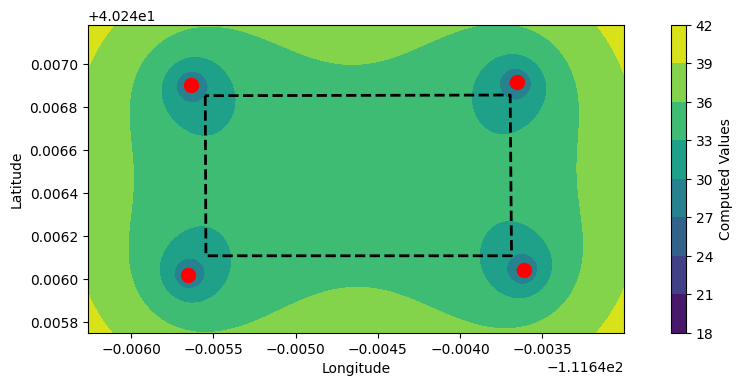

In [ ]:
contour_plot(h_grid, marker_coords, polygon_coords)


In [ ]:
# Filter the head values that are inside the excavation.
inside_mask = mask_inside_polygon(grid_x, grid_y, poly_x, poly_y)
h_grid_inside = filter_inside_polygon(inside_mask, h_grid)


In [ ]:
# print the max value of h_grid_inside
print(f"Max value of h_grid_inside: {np.nanmax(h_grid_inside)}")

Max value of h_grid_inside: 35.35306875191711


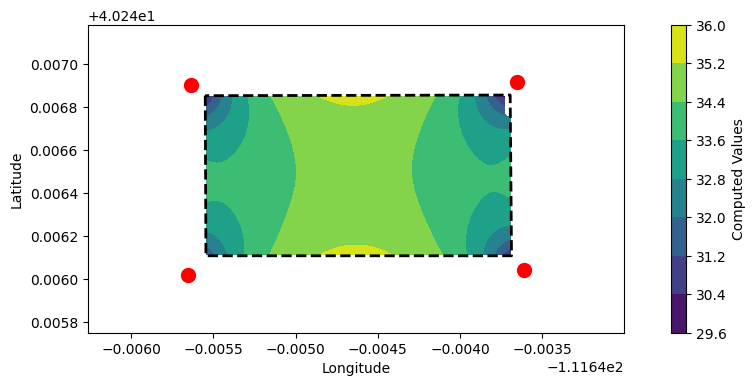

In [ ]:
# Plot the heads inside the excavation
contour_plot(h_grid_inside, marker_coords, polygon_coords)

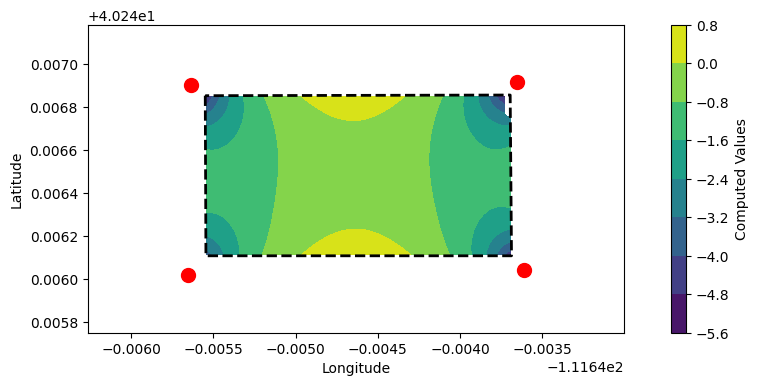

In [ ]:
# Create a new head array which is the h_grid minus design_head. Negative values indicate
# depth below the bottom of the excavation.
h_grid_new = h_grid_inside - design_head

contour_plot(h_grid_new, marker_coords, polygon_coords)

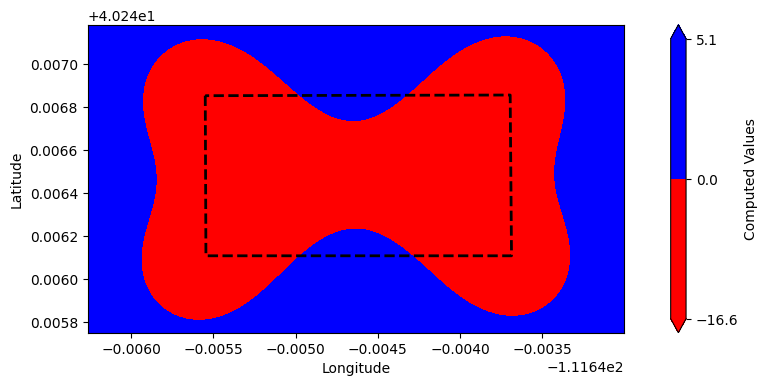

In [ ]:
# Create a depth below grid for the entire domain and then do a binary plot where
# values below a given depth are marked in red. This can graphically show where
# the dewatering objective has been met.

h_split = h_grid-design_head

cushion = 0  # Optional - extra depth for a factor of safety

contour_plot(h_split,marker_coords, polygon_coords, binary=True, binary_value=-cushion)

# Part 3 - Rectangular Well System Design

In this section we will generate a set of wells along a rectangle that is offset from the bounding box of the excavation, redo the head calculations, and plot the results.

In [ ]:
# Define functions for this section

def parse_geojson(geojson_data):
    # Parse GeoJSON to extract polygon coordinates
    geo_shape = shape(geojson_data['features'][0]['geometry'])
    if isinstance(geo_shape, Polygon):
        return list(geo_shape.exterior.coords)
    else:
        raise ValueError("GeoJSON does not contain a polygon.")

def project_coordinates(coords, transformer):
    # Project lat/lon to meters
    projected = []
    for lon, lat in coords:
        try:
            x, y = transformer.transform(lon, lat)
            projected.append((x, y))
        except Exception as e:
            print(f"Error projecting coordinate ({lat}, {lon}): {e}")
            projected.append((float('inf'), float('inf')))
    return projected

def generate_well_locations_geojson(geojson_data, offset_m, npts_x):

    from pyproj import Transformer

    # Step 1: Parse GeoJSON and get polygon coordinates
    polygon_coords = parse_geojson(geojson_data)

    #print("Parsed Coordinates (Lat/Lon):", polygon_coords)

    # Step 2: Set up a general-purpose transformer (EPSG:3857)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    inverse_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

    # Project polygon to meters
    projected_polygon = project_coordinates(polygon_coords, transformer)
    #print("Projected Coordinates (Meters):", projected_polygon)

    # Ensure there are valid projected coordinates
    if any(x == float('inf') or y == float('inf') for x, y in projected_polygon):
        raise ValueError("Projection failed for some coordinates. Please check input data and projection settings.")

    # Step 3: Compute bounding box in meters
    x_coords, y_coords = zip(*projected_polygon)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    #print("Bounding Box (Meters):", min_x, max_x, min_y, max_y)

    # Step 4: Expand the bounding box by the offset in meters
    min_x -= offset_m
    max_x += offset_m
    min_y -= offset_m
    max_y += offset_m

    # Step 5: Generate well locations along the expanded bounding box
    wells = []

    # Calculate spacing for east-west points
    spacing_x = (max_x - min_x) / (npts_x - 1)

    # Calculate the number of points in the north-south direction
    npts_y = int(round((max_y - min_y) / spacing_x)) + 1
    spacing_y = (max_y - min_y) / (npts_y - 1)

    print(f"Spacing in X: {spacing_x}")
    print(f"Spacing in Y: {spacing_y}")

    # Generate points along the bottom (south) edge
    for i in range(npts_x):
        x = min_x + i * spacing_x
        wells.append((x, min_y))

    # Generate points along the right (east) edge
    for i in range(1, npts_y - 1):  # Avoid corners
        y = min_y + i * spacing_y
        wells.append((max_x, y))

    # Generate points along the top (north) edge
    for i in range(npts_x):
        x = max_x - i * spacing_x
        wells.append((x, max_y))

    # Generate points along the left (west) edge
    for i in range(1, npts_y - 1):  # Avoid corners
        y = max_y - i * spacing_y
        wells.append((min_x, y))

    # Step 6: Convert well coordinates back to lat/lon
    well_coords_latlon = [(inverse_transformer.transform(x, y)) for x, y in wells]

    # Step 7: Reverse the order (x vs y) for the lat/lon coords
    well_coords_latlon = [(y, x) for x, y in well_coords_latlon]

    return well_coords_latlon

In [ ]:
# Generate a rectangular set of wells based on an offset distance from the edge
# of the excavation and a number of wells along the x-direction. Spacing in the
# y-direction is adjused to match

offset_m = 15
npts_x = 8

rect_wells_coords = generate_well_locations_geojson(geojson_data, offset_m, npts_x)

num_wells = len(rect_wells_coords)
print(f"Number of Wells: {num_wells}")

Spacing in X: 33.886500178171055
Spacing in Y: 34.69291284889914
Number of Wells: 22


In [ ]:
# Solve for the head using the rectangular ring of wells

qi = total_Q / num_wells
distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(rect_wells_coords, polygon_coords)
h_grid = solve_heads(distances, qi)

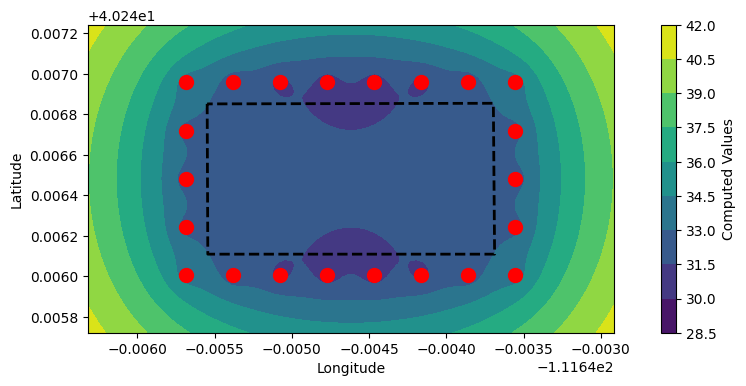

In [ ]:
contour_plot(h_grid, rect_wells_coords, polygon_coords)

# Part 4 - Pumping Rate Optimization

In this section, we use the rectangular well design from the previous section and optimize the pumping rate so that the resulting heads are just below the design depth.

In [ ]:
# Define functions for this section.

def objective_function(h_grid_inside, design_head):
  # find the max value in h_grid_inside, but ignore nans
  h_grid_nonans = h_grid_inside[~np.isnan(h_grid_inside)]
  max_h = np.max(h_grid_nonans)
  diff = max_h - design_head
  return diff # Should be zero if max head in excavation is right at the bottom

def optimize_pumping_rate_bisection(qi_low, qi_high, distances, tolerance=0.0001, max_iterations=100):
    """
    Optimize qi using the bisection method.

    Args:
        qi_low: Lower bound for pumping rate.
        qi_high: Upper bound for pumping rate.
        distances: Array of distances for simulation.
        tolerance: Acceptable difference between target and actual head.
        max_iterations: Maximum number of iterations.

    Returns:
        Optimal pumping rate (qi).
    """
    inside_mask = mask_inside_polygon(grid_x, grid_y, poly_x, poly_y)

    for iteration in range(max_iterations):
        qi_mid = (qi_low + qi_high) / 2
        h_grid = solve_heads(distances, qi_mid)
        h_grid_inside = filter_inside_polygon(inside_mask, h_grid)
        obj = objective_function(h_grid_inside, design_head)

        print(f"Iteration: {iteration}, qi_mid: {qi_mid:.6f}, Objective: {obj:.6f}")

        if np.abs(obj) < tolerance:
            print("Optimal pumping rate found.")
            return qi_mid

        if obj < 0:
            qi_high = qi_mid  # Reduce the upper bound
        else:
            qi_low = qi_mid   # Increase the lower bound

    print("Optimization did not converge within the maximum number of iterations.")
    return (qi_low + qi_high) / 2

In [ ]:
# Setup - run this in prep for next cell
distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(rect_wells_coords, polygon_coords)
inside_mask = mask_inside_polygon(grid_x, grid_y, poly_x, poly_y)

In [ ]:
# Run this cell repeatedly to find a pair of q values that give a head
# above and below the target (postive or negative value of obj).

q_test = 0.008

qi_test = q_test / num_wells
h_grid = solve_heads(distances, qi_test)
h_grid_inside = filter_inside_polygon(inside_mask, h_grid)
obj = objective_function(h_grid_inside, design_head)
print(f"Qi: {q_test}, Objective: {obj:0.2f}")

Qi: 0.008, Objective: 6.77


In [ ]:
# Use the two q values found in previous cell to initialize the solver and find optimal q

q_low = 0.008     # for positive result
q_high = 0.02    # for negative result

qi_low = q_low / num_wells
qi_high = q_high / num_wells
optimal_qi = optimize_pumping_rate_bisection(qi_low, qi_high, distances)
optimal_q = optimal_qi * num_wells
print(f"Optimal q: {optimal_q}")

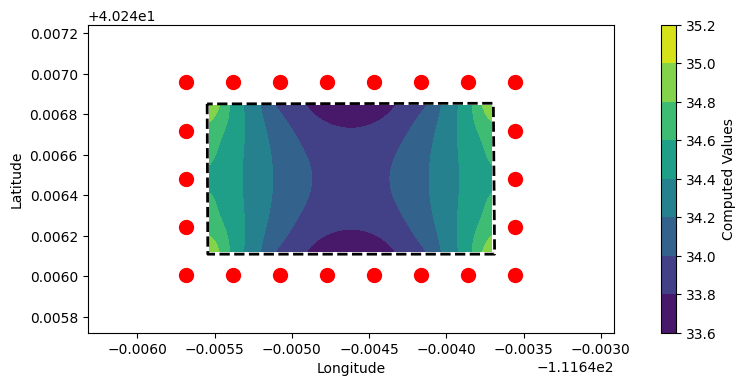

In [ ]:
h_grid = solve_heads(distances, optimal_qi)
inside_mask = mask_inside_polygon(grid_x, grid_y, poly_x, poly_y)
h_grid_inside = filter_inside_polygon(inside_mask, h_grid)

contour_plot(h_grid_inside, rect_wells_coords, polygon_coords)

In [ ]:
# Print final total design Q
q_total = optimal_qi * num_wells
print(f"Total pumping rate: {q_total:.5f} m^3/sec")

q_total_gpm = q_total * 15850.3
print(f"Total pumping rate: {q_total_gpm:.1f} gpm")

Total pumping rate: 0.01350 m^3/sec
Total pumping rate: 214.0 gpm


# Part 5 - Q vs NumWells Design Curve

In this section we will iterate and find the optimal Q for a range of well designs and plot the results. Specifically, we will vary the number of wells along the length of each side of the rectangle. This could be used to determine the point when adding more wells is not worth the extra cost.

In [ ]:
# Define functions used in this section

def opt_q_nwells(q_low, q_high, offset_m, npts_x):
  # Solve for the optimal total q for a given number of wells in the x direction

  print(f"Solving for nwell_x = : {npts_x}")

  # Compute the rectanqular grid coords
  rect_wells_coords = generate_well_locations_geojson(geojson_data, offset_m, npts_x)
  num_wells = len(rect_wells_coords)

  # Calculate distances
  distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(rect_wells_coords, polygon_coords)

  # Solve for optimal qi
  qi_low = q_low / num_wells
  qi_high = q_high / num_wells
  optimal_qi = optimize_pumping_rate_bisection(qi_low, qi_high, distances)
  optimal_q = optimal_qi * num_wells

  return optimal_q, num_wells

In [ ]:
# Run this cell repeatedly to find a pair of q values that give a head
# above and below the target (postive or negative value of obj).
# In this case we need to work in terms of total q because qi changes depending on
# number of wells. More specifically, you want a pair of q_test values that give
# a positive and negative objective for both your min npts_x and your max npts_x.

npts_x = 15
offset_m = 15

q_test = 0.015    # large value gives positive result, small value gives negative result

rect_wells_coords = generate_well_locations_geojson(geojson_data, offset_m, npts_x)
num_wells = len(rect_wells_coords)
distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(rect_wells_coords, polygon_coords)

qi_test = q_test / num_wells
h_grid = solve_heads(distances, qi_test)
inside_mask = mask_inside_polygon(grid_x, grid_y, poly_x, poly_y)
h_grid_inside = filter_inside_polygon(inside_mask, h_grid)
obj = objective_function(h_grid_inside, design_head)
print(f"Q: {q_test}, Objective: {obj:0.2f}")

Spacing in X: 16.943250089085527
Spacing in Y: 17.34645642444957
Q: 0.015, Objective: -2.26


In [ ]:
# Define inputs and solve

offset_m = 15

min_wells_x = 3
max_wells_x = 15

q_low = 0.01      # for positive result
q_high = 0.015     # for negative result

design_wells = []
design_q = []

for i in range(min_wells_x, max_wells_x + 1):
  optimal_q, num_wells = opt_q_nwells(q_low, q_high, offset_m, i)
  print(f"Number of Wells: {num_wells}, Optimal Q: {optimal_qi}")
  design_wells.append(num_wells)
  design_q.append(optimal_q)


Solving for nwell_x = : 3
Spacing in X: 118.6027506235987
Spacing in Y: 138.77165139559656
Iteration: 0, qi_mid: 0.002083, Objective: 2.508951
Iteration: 1, qi_mid: 0.002292, Objective: 1.022403
Iteration: 2, qi_mid: 0.002396, Objective: 0.255632
Iteration: 3, qi_mid: 0.002448, Objective: -0.134076
Iteration: 4, qi_mid: 0.002422, Objective: 0.061319
Iteration: 5, qi_mid: 0.002435, Objective: -0.036242
Iteration: 6, qi_mid: 0.002428, Objective: 0.012573
Iteration: 7, qi_mid: 0.002432, Objective: -0.011826
Iteration: 8, qi_mid: 0.002430, Objective: 0.000375
Iteration: 9, qi_mid: 0.002431, Objective: -0.005725
Iteration: 10, qi_mid: 0.002430, Objective: -0.002675
Iteration: 11, qi_mid: 0.002430, Objective: -0.001150
Iteration: 12, qi_mid: 0.002430, Objective: -0.000387
Iteration: 13, qi_mid: 0.002430, Objective: -0.000006
Optimal pumping rate found.
Number of Wells: 6, Optimal Q: 0.0006135794899680398
Solving for nwell_x = : 4
Spacing in X: 79.06850041573246
Spacing in Y: 69.3858256977982

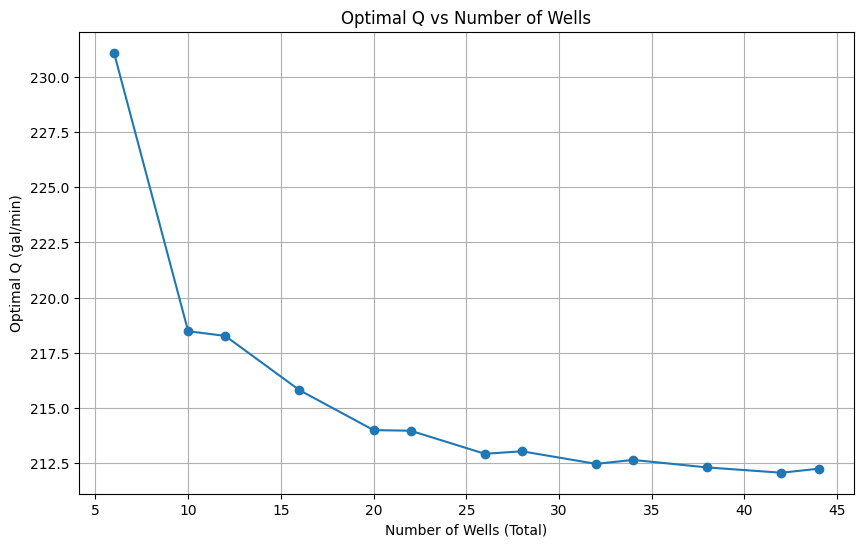

In [ ]:
# Convert design_q array from meters cubed per second to gallons per minute
design_q_gpm = [q * 15850.3 for q in design_q]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(design_wells, design_q_gpm, marker='o', linestyle='-')
plt.xlabel('Number of Wells (Total)')
plt.ylabel('Optimal Q (gal/min)')
plt.title('Optimal Q vs Number of Wells')
plt.grid(True)
plt.show()